[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set5/set5_prob2.ipynb)


# Problem 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# download the dataset
!wget -O train.txt https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set5/data/train.txt
!wget -O test.txt https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set5/data/test.txt

--2023-02-27 02:30:12--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set5/data/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 685602 (670K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 669.53K  --.-KB/s    in 0.04s   

2023-02-27 02:30:12 (14.8 MB/s) - ‘train.txt’ saved [685602/685602]

--2023-02-27 02:30:12--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set5/data/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293571 (

## 2C:
Fill in these functions to train your SVD

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regulariation parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    grad_ui = (reg * Ui - Vj * (Yij - np.dot(Ui,Vj))) * eta
    return grad_ui

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    grad_vj = (reg * Vj - Ui * (Yij - np.dot(Ui,Vj))) * eta
    return grad_vj

def get_err(U, V, Y, reg=0.0):

    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    Y_{ij} = (UV^T)_{ij} U @ np.transpose(V)
    """
    err = 0
    matrix = U @ np.transpose(V)
    for i,j,y_ij in Y:
      err += pow(y_ij - matrix[i-1][j-1],2)

    return (0.5 * err) / len(Y)  + ((reg/2) * (np.linalg.norm(U, ord = "fro")**2 + np.linalg.norm(V, ord = "fro")**2) / len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    U = np.random.rand(M,K) - 0.5
    V = np.random.rand(N,K) - 0.5

    zero_loss = get_err(U,V,Y,reg)
    first_loss = 0
    curr_loss = zero_loss
    prev_loss = 0

    for epoch in tqdm(range(max_epochs)):
      np.random.shuffle(Y)
      for i,j,y_ij in Y:
        Ui = U[i-1,:] - (grad_U(U[i-1,:], y_ij, V[j-1,:], reg, eta))
        Vj = V[j-1,:] - (grad_V(V[j-1,:], y_ij, U[i-1,:], reg, eta))
        U[i-1,:] = Ui
        V[j-1,:] = Vj
      prev_loss = curr_loss
      curr_loss = get_err(U,V,Y,reg)
      if epoch == 0:
        first_loss = get_err(U,V,Y,reg)
      if (prev_loss - curr_loss) / (zero_loss - first_loss) <= eps:
        break

    return (U,V,get_err(U,V,Y))


## 2D:
Run the cell below to get your graphs

Factorizing with  943  users,  1682  movies.


  6%|▌         | 17/300 [00:57<15:54,  3.37s/it]


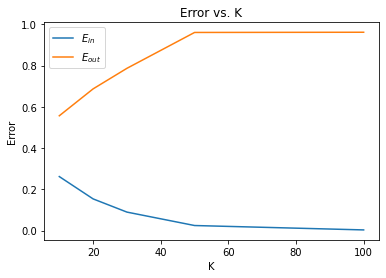

In [ ]:
Y_train = np.loadtxt('train.txt').astype(int)
Y_test = np.loadtxt('test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = [10,20,30,50,100]

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for K in Ks:
    U,V, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))

plt.plot(Ks, E_in, label='$E_{in}$')
plt.plot(Ks, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2d.png')

## 2E:
Run the cell below to get your graphs. This might take a long time to run, but it should take less than 2 hours. I would encourage you to validate your 2C is correct.

Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.0001


  6%|▌         | 17/300 [00:50<14:06,  2.99s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001


  7%|▋         | 21/300 [01:04<14:19,  3.08s/it]


Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.0001


  9%|▉         | 27/300 [01:19<13:25,  2.95s/it]


Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.0001


  9%|▊         | 26/300 [01:19<13:56,  3.05s/it]


Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 0.0001


  5%|▌         | 16/300 [00:54<16:04,  3.40s/it]


Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.001


  5%|▌         | 15/300 [00:44<14:11,  2.99s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.001


  7%|▋         | 22/300 [01:05<13:48,  2.98s/it]


Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.001


  9%|▉         | 27/300 [01:20<13:38,  3.00s/it]


Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.001


  8%|▊         | 25/300 [01:14<13:41,  2.99s/it]


Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 0.001


  5%|▌         | 15/300 [00:52<16:37,  3.50s/it]


Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.01


  6%|▋         | 19/300 [00:56<13:49,  2.95s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.01


  7%|▋         | 21/300 [01:03<13:59,  3.01s/it]


Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.01


  7%|▋         | 21/300 [01:03<14:03,  3.02s/it]


Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.01


  9%|▉         | 28/300 [01:23<13:31,  2.98s/it]


Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 0.01


  6%|▌         | 17/300 [00:57<16:01,  3.40s/it]


Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 0.1


  3%|▎         | 9/300 [00:30<16:22,  3.38s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1


  5%|▌         | 16/300 [00:49<14:44,  3.11s/it]


Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 0.1


  6%|▋         | 19/300 [00:58<14:23,  3.07s/it]


Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 0.1


  7%|▋         | 21/300 [01:05<14:33,  3.13s/it]


Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 0.1


  2%|▏         | 7/300 [00:25<18:00,  3.69s/it]


Training model with M = 943, N = 1682, k = 10, eta = 0.03, reg = 1


  2%|▏         | 5/300 [00:17<17:29,  3.56s/it]


Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1


  2%|▏         | 5/300 [00:18<18:04,  3.68s/it]


Training model with M = 943, N = 1682, k = 30, eta = 0.03, reg = 1


  1%|▏         | 4/300 [00:15<18:31,  3.76s/it]


Training model with M = 943, N = 1682, k = 50, eta = 0.03, reg = 1


  1%|          | 3/300 [00:12<20:26,  4.13s/it]


Training model with M = 943, N = 1682, k = 100, eta = 0.03, reg = 1


  1%|          | 3/300 [00:13<22:23,  4.52s/it]


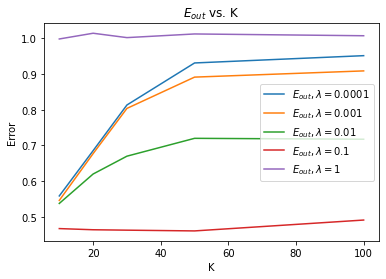

In [ ]:
Y_train = np.loadtxt('train.txt').astype(int)
Y_test = np.loadtxt('test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
Ks = [10,20,30,50,100]

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_ins = []
E_outs = []

# Use to compute Ein and Eout
for reg in regs:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for k in Ks:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
        U,V, e_in = train_model(M, N, k, eta, reg, Y_train)
        E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, Y_test)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)


# Plot values of E_in across k for each value of lambda
for i in range(len(regs)):
    plt.plot(Ks, E_ins[i], label='$E_{in}, \lambda=$'+str(regs[i]))
plt.title('$E_{in}$ vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_ein.png')
plt.clf()

# Plot values of E_out across k for each value of lambda
for i in range(len(regs)):
    plt.plot(Ks, E_outs[i], label='$E_{out}, \lambda=$'+str(regs[i]))
plt.title('$E_{out}$ vs. K')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_eout.png')
